In [1]:
#!/usr/bin/env python3.4

import os
import sys
import re
import uuid
import random
import imageio
import numpy as np
import torch
import torch_scatter
import matplotlib.pyplot as plt
import torchvision.transforms as T

sys.path.append('../')

from scipy import misc
from PIL import Image
from tqdm import tqdm
from omegaconf import OmegaConf, DictConfig
from evaluation import eval_utils as eu

/tmp/ipykernel_69470/3543871297.py:17: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


In [2]:
def contract_to_unisphere(
    x: torch.Tensor,
    ord: float = 2,
    eps: float = 1e-6,
    derivative: bool = False,
    cdf_lb: float = 0.1,
    num_bins: int = 1000,
):  
    x_pdf, x_pos = torch.histogram(x[:, 0].cpu(), bins=num_bins)
    y_pdf, y_pos = torch.histogram(x[:, 1].cpu(), bins=num_bins)
    z_pdf, z_pos = torch.histogram(x[:, 2].cpu(), bins=num_bins)
    x_cdf, x_pos = torch.cumsum(x_pdf, dim=0) / x.shape[0], x_pos[:-1]
    y_cdf, y_pos = torch.cumsum(y_pdf, dim=0) / x.shape[0], y_pos[:-1]
    z_cdf, z_pos = torch.cumsum(z_pdf, dim=0) / x.shape[0], z_pos[:-1]

    aabb = torch.tensor([
        x_pos[x_cdf > cdf_lb].min(),
        y_pos[y_cdf > cdf_lb].min(),
        z_pos[z_cdf > cdf_lb].min(),
        x_pos[x_cdf > 1 - cdf_lb].min(),
        y_pos[y_cdf > 1 - cdf_lb].min(),
        z_pos[z_cdf > 1 - cdf_lb].min(),
    ], device=x.device)
    aabb_min, aabb_max = torch.split(aabb, aabb.shape[0] // 2, dim=-1)
    x = (x - aabb_min) / (aabb_max - aabb_min)
    x = x * 2 - 1  # aabb is at [-1, 1]
    mag = torch.linalg.norm(x, ord=ord, dim=-1, keepdim=True)
    mask = mag.squeeze(-1) > 1

    if derivative:
        dev = (2 * mag - 1) / mag**2 + 2 * x**2 * (
            1 / mag**3 - (2 * mag - 1) / mag**4
        )
        dev[~mask] = 1.0
        dev = torch.clamp(dev, min=eps)
        return dev
    else:
        x[mask] = (2 - 1 / mag[mask]) * (x[mask] / mag[mask])
        x = x / 4 + 0.5  # [-inf, inf] is at [0, 1]
        return x

def get_flowid(frames, flows):
    N, _, H, W = frames.shape
    flow_ids = torch.ones_like(frames[:, 0], dtype=torch.int64) * -1
    flow_ids[0] = torch.arange(H * W).view(H, W)
    last_id = H * W

    grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W))
    grid_y = grid_y.to(device=frames.device)
    grid_x = grid_x.to(device=frames.device)
    diff_threshold = frames.max().item() * 0.1
    for i in tqdm(range(1, N), desc="Assigning flow ids"):
        x = (grid_x + flows[i-1, 0]).round().to(torch.int64)
        y = (grid_y + flows[i-1, 1]).round().to(torch.int64)
        mask = (x >= 0) & (x < W) & (y >= 0) & (y < H)
        # cut off flow when error is significant
        diff_mask = (frames[i, :, y[mask], x[mask]] - frames[i-1, :, grid_y[mask], grid_x[mask]]).abs().max(dim=0).values < diff_threshold
        flow_ids[i, y[mask][diff_mask], x[mask][diff_mask]] = flow_ids[i-1, grid_y[mask][diff_mask], grid_x[mask][diff_mask]]

        unassigned = (flow_ids[i] == -1)
        flow_ids[i, unassigned] = last_id + torch.arange(unassigned.sum(), device=frames.device)
        last_id += unassigned.sum()
    
    return flow_ids

def voxelization(flow_ids, in_feats_rgb, in_feats_coord, voxel_size, xyz_min=None, contract=False):
    with torch.no_grad():
        # automatically determine the voxel size
        _, unq_inv_t, _ = torch.unique(flow_ids, return_inverse=True, return_counts=True, dim=0)
        feats_rgb = torch_scatter.scatter(in_feats_rgb, unq_inv_t, dim=0, reduce='mean')
        feats_coord = torch_scatter.scatter(in_feats_coord, unq_inv_t, dim=0, reduce='mean')

        # contract to unit sphere
        # decide aabb according to density
        if contract:
            feats_coord = contract_to_unisphere(feats_coord, ord=torch.inf)
        if xyz_min is None:
            xyz_min = torch.min(feats_coord, dim=0).values
        voxel_size = torch.tensor([voxel_size] * 3, dtype=feats_coord.dtype, device=feats_coord.device)
        voxel_index = torch.div(feats_coord - xyz_min[None, :], voxel_size[None, :], rounding_mode='floor')
        voxel_coords = voxel_index * voxel_size[None, :] + xyz_min[None, :] + voxel_size[None, :] / 2
        feats_coord, unq_inv_xyz, _ = torch.unique(voxel_coords, return_inverse=True, return_counts=True, dim=0)
        feats_rgb = torch_scatter.scatter(feats_rgb, unq_inv_xyz, dim=0, reduce='mean')

        unq_inv = unq_inv_xyz[unq_inv_t]

        return unq_inv

In [34]:
output_dir = "../workdir/sceneflow/sceneflow_highres_test_lmr_0.01_gmr_0.01"
config = OmegaConf.load(os.path.join(output_dir, 'config.yaml'))

if config.data.scene_type.lower() == "sceneflow":
    from utils.dataparsers import SceneFlowDataParser
    config.data.data_dir = os.path.join('../', config.data.data_dir)  # update relative path for notebook
    data_parser = SceneFlowDataParser(config.data, config.device)
    frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
    flows, _ = data_parser.load_flow(frame_ids, future_flow=True);
    frames, coords_w = data_parser.load_video(frame_ids);
else:
    raise NotImplementedError(f"Scene type {config.data.scene_type} is not supported.")

Reading camera data: 100%|██████████| 300/300 [00:00<00:00, 63259.32it/s]


[INFO] frame indexes:  28 29 ... 126 127


Loading Data: 100%|██████████| 300/300 [00:00<00:00, 1119.69it/s]


[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)


Loading Data: 100%|██████████| 300/300 [00:00<00:00, 1177.63it/s]


[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)


Loading Data: 100%|██████████| 300/300 [00:02<00:00, 115.26it/s]


[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)
[INFO] frame size (540, 960) resize to (540, 960) and centercrop to (512, 960)


Assigning flow ids: 100%|██████████| 99/99 [00:00<00:00, 554.20it/s]


## 0. Cluster Points according to Flow

In [38]:
# assign each pixel a flow id
N, _, H, W = frames.shape
flow_ids = torch.ones_like(frames[:, 0], dtype=torch.int64) * -1
flow_ids[0] = torch.arange(H * W).view(H, W)
last_id = H * W

grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W))
grid_y = grid_y.to(device=frames.device)
grid_x = grid_x.to(device=frames.device)
diff_threshold = frames.max().item() * 0.1
for i in tqdm(range(1, N), desc="Assigning flow ids"):
    x = (grid_x + flows[i-1, 0]).round().to(torch.int64)
    y = (grid_y + flows[i-1, 1]).round().to(torch.int64)
    mask = (x >= 0) & (x < W) & (y >= 0) & (y < H)
    # cut off flow when error is significant
    diff_mask = (frames[i, :, y[mask], x[mask]] - frames[i-1, :, grid_y[mask], grid_x[mask]]).abs().max(dim=0).values < 0.1
    flow_ids[i, y[mask][diff_mask], x[mask][diff_mask]] = flow_ids[i-1, grid_y[mask][diff_mask], grid_x[mask][diff_mask]]

    unassigned = (flow_ids[i] == -1)
    flow_ids[i, unassigned] = last_id + torch.arange(unassigned.sum(), device=frames.device)
    last_id += unassigned.sum()

print(f"Total number of flow ids: {last_id} / {N * H * W}")

Assigning flow ids:  55%|█████▍    | 54/99 [00:00<00:00, 535.00it/s]

Assigning flow ids: 100%|██████████| 99/99 [00:00<00:00, 571.61it/s]

Total number of flow ids: 21167232 / 49152000


In [40]:
flow_ids = flow_ids.reshape(-1)
feats_rgb = frames.permute(0, 2, 3, 1).reshape(-1, 3)
feats_coord = coords_w.permute(0, 2, 3, 1).reshape(-1, 3)
_, unq_inv_t, _ = torch.unique(flow_ids, return_inverse=True, return_counts=True, dim=0)
feats_rgb = torch_scatter.scatter(feats_rgb, unq_inv_t, dim=0, reduce='mean')
feats_coord = torch_scatter.scatter(feats_coord, unq_inv_t, dim=0, reduce='mean')

# contract to unit sphere
# decide aabb according to density
feats_coord = contract_to_unisphere(feats_coord, ord=torch.inf)
voxel_size = torch.tensor([1e-4] * 3, dtype=feats_coord.dtype, device=feats_coord.device)
xyz_min = torch.min(feats_coord, dim=0).values
voxel_index = torch.div(feats_coord - xyz_min[None, :], voxel_size[None, :], rounding_mode='floor')
voxel_coords = voxel_index * voxel_size[None, :] + xyz_min[None, :] + voxel_size[None, :] / 2
feats_coord, unq_inv_xyz, _ = torch.unique(voxel_coords, return_inverse=True, return_counts=True, dim=0)
feats_rgb = torch_scatter.scatter(feats_rgb, unq_inv_xyz, dim=0, reduce='mean')
print(f"Total number of unique voxels: {feats_rgb.shape[0]} / {N * H * W}")

unq_inv = unq_inv_xyz[unq_inv_t]
new_frames = feats_rgb[unq_inv].reshape(N, H, W, 3).permute(0, 3, 1, 2)
del unq_inv_t, unq_inv_xyz

Total number of unique voxels: 16888404 / 49152000


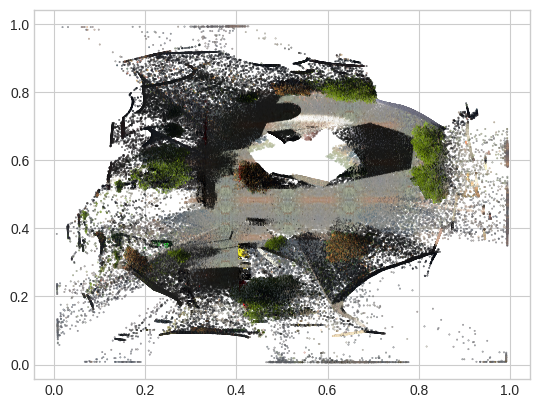

In [41]:
interval = 50
pcd_xyz = feats_coord.cpu().numpy()[::interval]
pcd_rgb = feats_rgb.cpu().numpy()[::interval]
# mask = (pcd_xyz[:, 0] > -100) & (pcd_xyz[:, 0] < 200) & (pcd_xyz[:, 1] > -100) & (pcd_xyz[:, 1] < 200)
# pcd_xyz = pcd_xyz[mask]
# pcd_rgb = pcd_rgb[mask]
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure()
plt.scatter(pcd_xyz[:, 0], pcd_xyz[:, 1], c=pcd_rgb, s=0.1)
# plt.xlim(0, 150)
# plt.ylim(-50, 150)
plt.show()

(-0.5, 959.5, 511.5, -0.5)

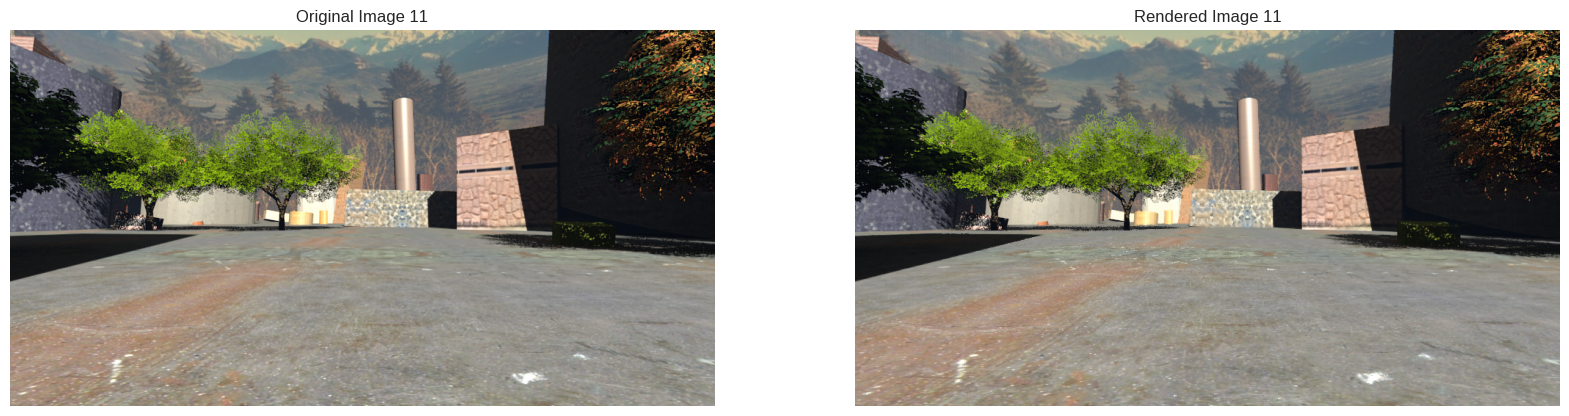

In [42]:
idx = random.randint(0, len(frame_ids) - 1)
# idx = 50
pil_img = frames[idx].cpu().numpy().transpose(1, 2, 0)
rendered_img = new_frames[idx].cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(pil_img)
plt.title(f'Original Image {idx}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rendered_img)
plt.title(f'Rendered Image {idx}')
plt.axis('off')

(-0.5, 959.5, 511.5, -0.5)

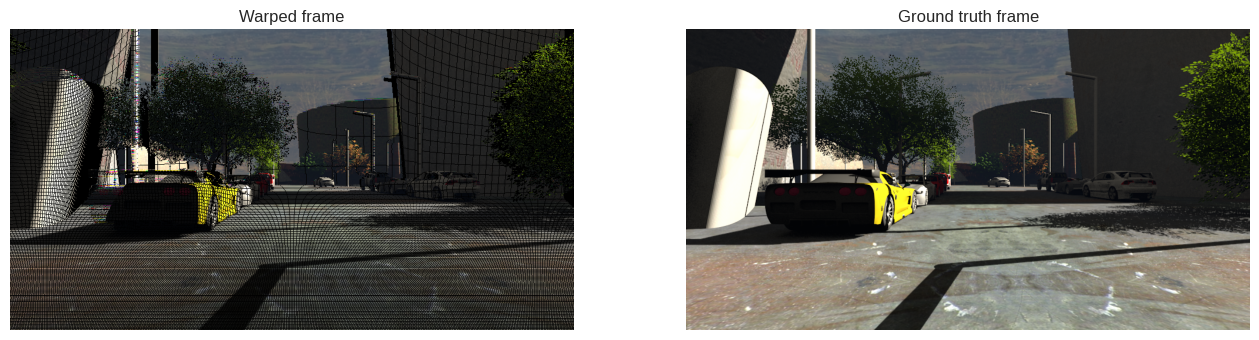

In [148]:
# i = random.randint(1, len(frame_ids) - 1)
i = 89
x = (grid_x + data_parser.flows[i-1, 0]).round().to(torch.int64)
y = (grid_y + data_parser.flows[i-1, 1]).round().to(torch.int64)
mask = (x >= 0) & (x < W) & (y >= 0) & (y < H)
frame_warp = torch.zeros_like(frames[i])
frame_warp[:, y[mask], x[mask]] = frames[i-1, :, grid_y[mask], grid_x[mask]]
frame_warp = frame_warp.permute(1, 2, 0).cpu().numpy()
frame_warp_gt = frames[i].permute(1, 2, 0).cpu().numpy()

# frame_warp[:, grid_y[mask], grid_x[mask]] = frames[i-1, :, y[mask], x[mask]]
# frame_warp = frame_warp.permute(1, 2, 0).cpu().numpy()
# frame_warp_gt = frames[i].permute(1, 2, 0).cpu().numpy()

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(frame_warp)
plt.title("Warped frame")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(frame_warp_gt)
plt.title("Ground truth frame")
plt.axis("off")

## 1. Visualize Data Sample

In [3]:
video_path = f'{output_dir}/output.gif'
pil_list = eu.video_to_pil_list(video_path)
pil_tensor = torch.concat([eu.load_image(pil, config.device) for pil in pil_list], dim=0)
N, _, H, W = pil_tensor.shape
pil_tensor = pil_tensor.permute(0, 2, 3, 1).reshape(N*H*W, -1)
pil_tensor = torch_scatter.scatter(pil_tensor, data_parser.unq_inv, dim=0, reduce='mean')

In [5]:
interval = 50
pcd_xyz = data_parser.new_coors.reshape(-1, 3).cpu().numpy()[::interval]
pcd_rgb = pil_tensor.reshape(-1, 3).cpu().numpy()[::interval]
# mask = (pcd_xyz[:, 0] > -100) & (pcd_xyz[:, 0] < 200) & (pcd_xyz[:, 1] > -100) & (pcd_xyz[:, 1] < 200)
# pcd_xyz = pcd_xyz[mask]
# pcd_rgb = pcd_rgb[mask]

from plyfile import PlyData, PlyElement
# 确保输入数组形状正确
assert pcd_xyz.shape[0] == pcd_rgb.shape[0], "坐标和颜色数组的点数量不一致"
assert pcd_xyz.shape[1] == 3, "坐标数组应为(N, 3)"
assert pcd_rgb.shape[1] == 3, "颜色数组应为(N, 3)"

# 转换颜色到uint8（假设颜色值在0-255或0-1范围内）
if pcd_rgb.dtype != np.uint8:
    if np.max(pcd_rgb) <= 1.0:
        pcd_rgb = (pcd_rgb * 255).astype(np.uint8)
    else:
        pcd_rgb = pcd_rgb.astype(np.uint8)

# 创建结构化数组
vertex_dtype = [('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
                ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]
vertices = np.empty(pcd_xyz.shape[0], dtype=vertex_dtype)

# 填充数据
vertices['x'] = pcd_xyz[:, 0].astype('f4')
vertices['y'] = pcd_xyz[:, 1].astype('f4')
vertices['z'] = pcd_xyz[:, 2].astype('f4')
vertices['red'] = pcd_rgb[:, 0]
vertices['green'] = pcd_rgb[:, 1]
vertices['blue'] = pcd_rgb[:, 2]

# 生成并保存PLY文件
ply_element = PlyElement.describe(vertices, 'vertex')
PlyData([ply_element]).write('colored_point_cloud.ply')

In [4]:
pil_tensor = pil_tensor[data_parser.unq_inv].reshape(N, H, W, -1).permute(0, 3, 1, 2)

(-0.5, 959.5, 511.5, -0.5)

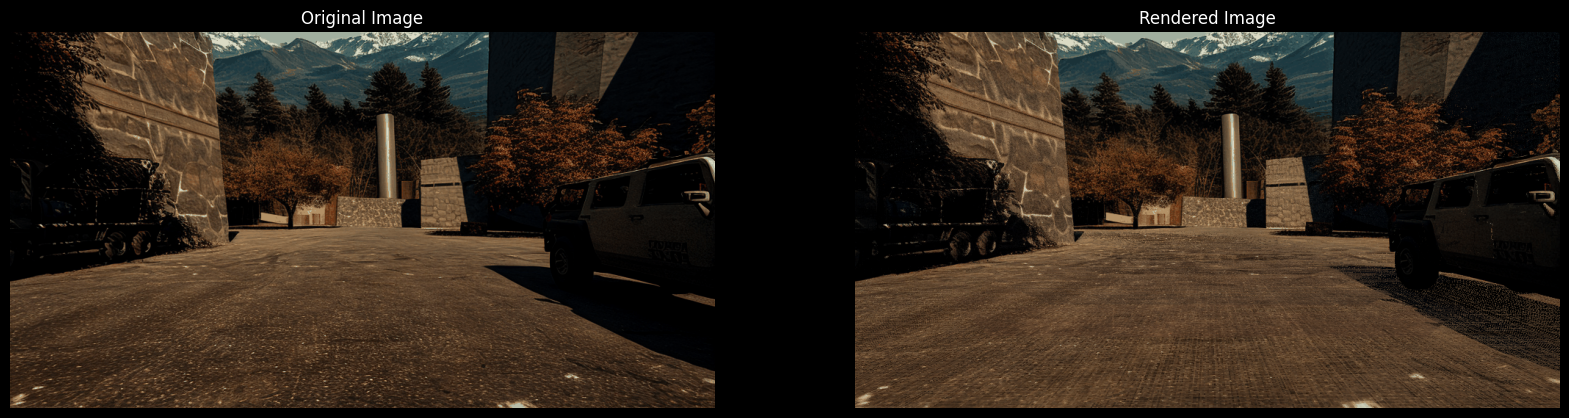

In [10]:
idx = random.randint(0, len(data_parser.frame_ids) - 1)
# idx = 9
pil_img = pil_list[idx]
rendered_img = pil_tensor[idx].cpu().numpy().transpose(1, 2, 0) / 255.0

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(pil_img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rendered_img)
plt.title('Rendered Image')
plt.axis('off')